In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"junaidio","key":"501b6112c0040dbe0263fb0a5da8ced2"}'}

In [2]:
import os
import zipfile

# Make a kaggle folder and move the key there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Give correct permissions
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# Download dataset from Kaggle
!kaggle datasets download -d drgfreeman/rockpaperscissors

# Unzip it
with zipfile.ZipFile("rockpaperscissors.zip","r") as zip_ref:
    zip_ref.extractall("rockpaperscissors_data")


Dataset URL: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors
License(s): CC-BY-SA-4.0
 85% 260M/306M [00:00<00:00, 729MB/s] 
100% 306M/306M [00:00<00:00, 784MB/s]


In [4]:
# Check dataset contents
import os
os.listdir("rockpaperscissors_data")


['README_rpc-cv-images.txt', 'scissors', 'paper', 'rps-cv-images', 'rock']

## Imported the necessary libraries

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix


## Loaded the data

In [6]:
base_dir = '/content/rockpaperscissors_data/rps-cv-images'

paper_dir = os.path.join(base_dir, 'paper')
rock_dir = os.path.join(base_dir, 'rock')
scissors_dir = os.path.join(base_dir, 'scissors')

print("Paper images:", len(os.listdir(paper_dir)))
print("Rock images:", len(os.listdir(rock_dir)))
print("Scissors images:", len(os.listdir(scissors_dir)))


Paper images: 712
Rock images: 726
Scissors images: 750


## Printed some pictures

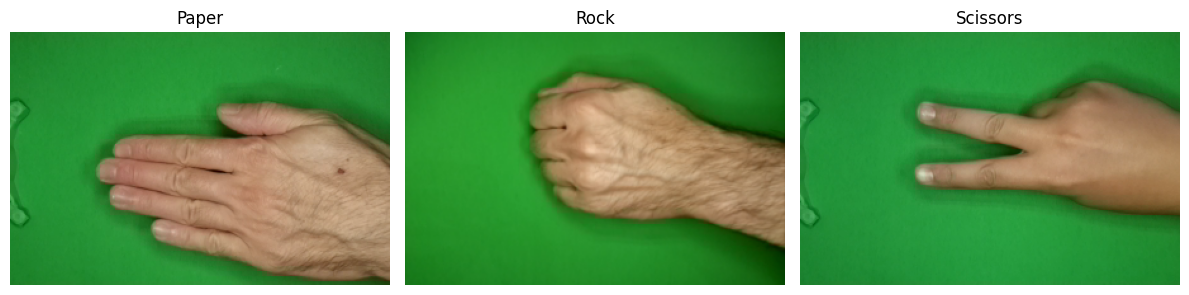

In [7]:
import random
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for ax, folder, title in zip(axs, [paper_dir, rock_dir, scissors_dir], ["Paper", "Rock", "Scissors"]):
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
import shutil
import os

# Path to your dataset folder
dataset_path = "/content/rockpaperscissors_data/rps-cv-images"

# Check if .ipynb_checkpoints exists and remove it
checkpoint_path = os.path.join(dataset_path, ".ipynb_checkpoints")
if os.path.exists(checkpoint_path):
    shutil.rmtree(checkpoint_path)
    print("Removed .ipynb_checkpoints folder")


## Generated some data and loaded it into the batches

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    seed=42
)
val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    seed=42,
    shuffle=False
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


In [10]:
print(train_gen.class_indices)
print(val_gen.class_indices)


{'paper': 0, 'rock': 1, 'scissors': 2}
{'paper': 0, 'rock': 1, 'scissors': 2}


## Simple CNN Model

In [11]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPool2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPool2D(2,2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

## Check points

In [12]:
ckpt = callbacks.ModelCheckpoint(
    'rps_model.h5',
    save_best_only=True,
    monitor='val_accuracy'
)

early = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

## Model training

In [13]:
history = model.fit(
    train_gen,
    epochs=30,
    validation_data=val_gen,
    callbacks=[ckpt, early]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.3982 - loss: 1.1551

55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.3996 - loss: 1.1530 - val_accuracy: 0.6682 - val_loss: 0.8119
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6921 - loss: 0.7142

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.6931 - loss: 0.7128 - val_accuracy: 0.8696 - val_loss: 0.3871
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - accuracy: 0.8383 - loss: 0.4325 - val_accuracy: 0.8558 - val_loss: 0.3746
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8607 - loss: 0.4072

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.8610 - loss: 0.4062 - val_accuracy: 0.9336 - val_loss: 0.1955
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9079 - loss: 0.2743

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 307ms/step - accuracy: 0.9081 - loss: 0.2741 - val_accuracy: 0.9359 - val_loss: 0.1693
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9224 - loss: 0.2406

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 286ms/step - accuracy: 0.9225 - loss: 0.2405 - val_accuracy: 0.9565 - val_loss: 0.1489
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9484 - loss: 0.1683

55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 305ms/step - accuracy: 0.9484 - loss: 0.1682 - val_accuracy: 0.9657 - val_loss: 0.0946
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9640 - loss: 0.1276

55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 288ms/step - accuracy: 0.9638 - loss: 0.1281 - val_accuracy: 0.9748 - val_loss: 0.0998
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.9481 - loss: 0.1421 - val_accuracy: 0.9542 - val_loss: 0.1266
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9639 - loss: 0.1138

55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 342ms/step - accuracy: 0.9639 - loss: 0.1138 - val_accuracy: 0.9863 - val_loss: 0.0522
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 289ms/step - accuracy: 0.9695 - loss: 0.1103 - val_accuracy: 0.9680 - val_loss: 0.0927
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.9705 - loss: 0.0947 - val_accuracy: 0.9817 - val_loss: 0.0643
Epoch 13/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 296ms/step - accuracy: 0.9606 - loss: 0.1281 - val_accuracy: 0.9703 - val_loss: 0.0710
Epoch 14/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.9711 - loss: 0.1020 - val_accuracy: 0.9725 - val_loss: 0.0723
Epoch 15/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 17s 313ms/step - accuracy: 0.9774 - loss: 0.0763 - val_accuracy: 0.9771 - val_loss: 0.0583


## Ploting the losses and accuracies

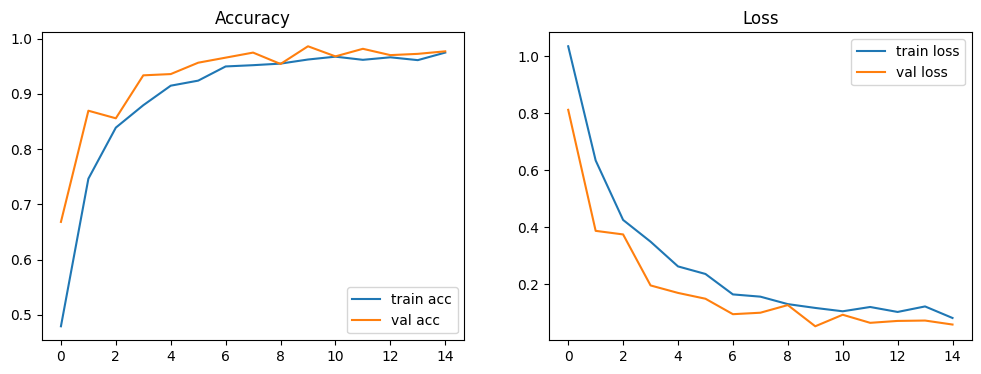

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.show()


In [15]:
val_loss, val_acc = model.evaluate(val_gen)
print(f'Validation accuracy: {val_acc:.4f}')

# Confusion matrix & report
Y_true = val_gen.classes
Y_pred = np.argmax(model.predict(val_gen), axis=1)

print(classification_report(
    Y_true,
    Y_pred,
    target_names=list(train_gen.class_indices.keys())
))

print(confusion_matrix(Y_true, Y_pred))


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - accuracy: 0.9776 - loss: 0.0704
Validation accuracy: 0.9863
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step
              precision    recall  f1-score   support

       paper       0.99      0.93      0.96       142
        rock       0.97      0.99      0.98       145
    scissors       0.96      0.99      0.97       150

    accuracy                           0.97       437
   macro avg       0.97      0.97      0.97       437
weighted avg       0.97      0.97      0.97       437

[[132   4   6]
 [  1 144   0]
 [  1   1 148]]


## Saving the model & Infrance

In [16]:
model.save('rps_cnn_model.h5')

In [17]:
from tensorflow.keras.models import load_model
model = load_model('/content/rps_cnn_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
Actual Label:    rock
Predicted Label: rock
Confidence:      0.9989


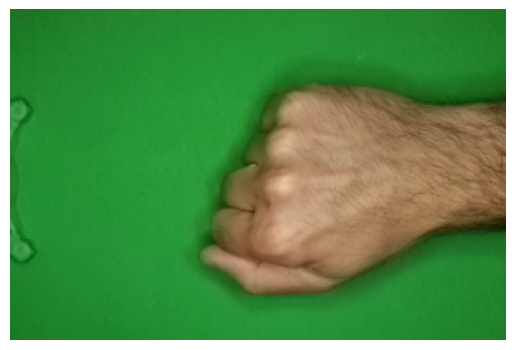

In [18]:
def predict_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150,150))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    classes = list(train_gen.class_indices.keys())
    predicted_label = classes[np.argmax(prediction)]
    actual_label = os.path.basename(os.path.dirname(img_path))

    print("Actual Label:   ", actual_label)
    print("Predicted Label:", predicted_label)
    print("Confidence:     ", round(np.max(prediction), 4))

    plt.imshow(plt.imread(img_path))
    plt.axis("off")
    plt.show()

def get_random_image():
    class_folders = [paper_dir, rock_dir, scissors_dir]
    chosen_folder = random.choice(class_folders)
    chosen_image = random.choice(os.listdir(chosen_folder))
    return os.path.join(chosen_folder, chosen_image)

sample_img = get_random_image()
predict_image(sample_img)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Class names (must match your training order)
classes = ["paper", "rock", "scissors"]

def predict_image(img_path):
    # Load and resize image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))

    # Convert to array and normalize
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = model.predict(img_array)

    # Get predicted label
    predicted_label = classes[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Show image + prediction
    plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


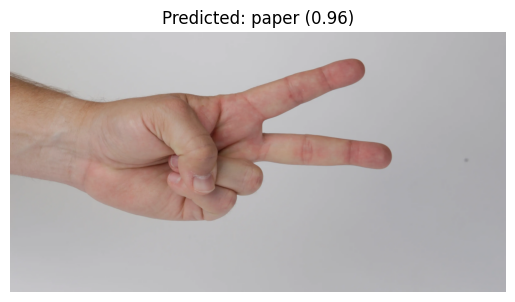

In [39]:
img_path = "/content/1398969360000-XXX-ROCKPAPERSCISSORS-APS0170-.webp"

predict_image(img_path)

> The model performing the good on the train data but lacking on outside data, so i will use a pretrained model

In [21]:
from tensorflow.keras.applications import MobileNetV2

In [22]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    seed=42
)
val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    seed=42,
    shuffle=False
)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.


## Mobilenet v2

In [23]:
base_model = MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[ckpt, early]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 70s 964ms/step - accuracy: 0.8117 - loss: 0.4840 - val_accuracy: 0.9748 - val_loss: 0.0475
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 512ms/step - accuracy: 0.9881 - loss: 0.0557 - val_accuracy: 0.9863 - val_loss: 0.0334
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.9841 - loss: 0.0576

55/55 ━━━━━━━━━━━━━━━━━━━━ 33s 596ms/step - accuracy: 0.9841 - loss: 0.0574 - val_accuracy: 0.9977 - val_loss: 0.0115
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 496ms/step - accuracy: 0.9908 - loss: 0.0373 - val_accuracy: 0.9931 - val_loss: 0.0200
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 28s 502ms/step - accuracy: 0.9886 - loss: 0.0339 - val_accuracy: 0.9954 - val_loss: 0.0115
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 528ms/step - accuracy: 0.9920 - loss: 0.0248 - val_accuracy: 0.9931 - val_loss: 0.0206
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 559ms/step - accuracy: 0.9845 - loss: 0.0398 - val_accuracy: 0.9977 - val_loss: 0.0081
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 31s 560ms/step - accuracy: 0.9945 - loss: 0.0184 - val_accuracy: 0.9977 - val_loss: 0.0085
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 27s 491ms/step - accuracy: 0.9908 - loss: 0.0210 - val_accuracy: 0.9954 - val_loss: 0.0112
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 531ms/step - accuracy: 0.9919 - loss: 0.0250 - val_accuracy: 0.99

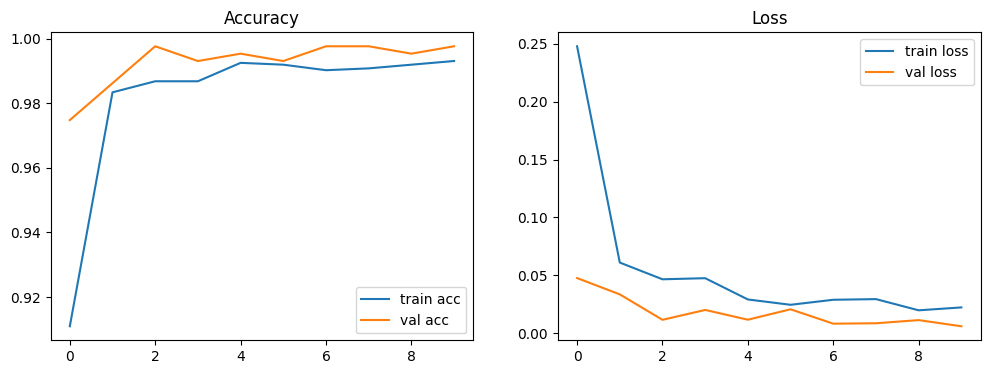

In [25]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.show()


In [26]:
val_loss, val_acc = model.evaluate(val_gen)
print(f'Validation accuracy: {val_acc:.4f}')

# Confusion matrix & report
Y_true = val_gen.classes
Y_pred = np.argmax(model.predict(val_gen), axis=1)

print(classification_report(
    Y_true,
    Y_pred,
    target_names=list(train_gen.class_indices.keys())
))

print(confusion_matrix(Y_true, Y_pred))


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 431ms/step - accuracy: 1.0000 - loss: 0.0042
Validation accuracy: 1.0000
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 699ms/step
              precision    recall  f1-score   support

       paper       1.00      1.00      1.00       142
        rock       1.00      1.00      1.00       145
    scissors       1.00      1.00      1.00       150

    accuracy                           1.00       437
   macro avg       1.00      1.00      1.00       437
weighted avg       1.00      1.00      1.00       437

[[142   0   0]
 [  0 145   0]
 [  0   0 150]]


In [27]:
model.save('mobile_net_rps.h5')

In [28]:
model = load_model('/content/mobile_net_rps.h5')

In [36]:
def predict_with_saved_model(model_path, img_path, class_indices):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(model_path)

    # Get class names in correct order
    classes = list(class_indices.keys())

    # Load & preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    prediction = loaded_model.predict(img_array, verbose=0)
    predicted_label = classes[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Show result
    plt.imshow(tf.keras.preprocessing.image.load_img(img_path))
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})")
    plt.show()

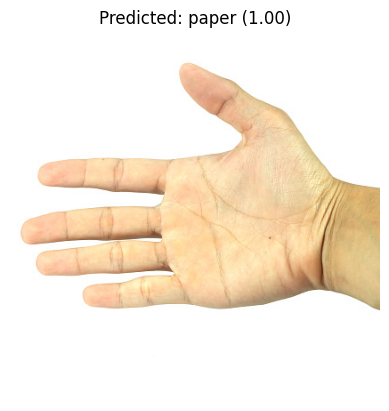

In [40]:
predict_with_saved_model("/content/mobile_net_rps.h5", "/content/istockphoto-484819314-170667a.jpg", train_gen.class_indices)

> This time it predicted perfectly